In [1]:
import pandas as pd
import numpy as np
import os
import time
import pickle
import json
from bs4 import BeautifulSoup
import requests
# !pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn

In [2]:
cwd = os.getcwd()

## Create dataframe of all stocks data from the funds' data we scraped (by selected dates)

In [3]:
def creat_all_stocks_data(cik_list,columns_input, agg_dict,start_date,end_date):
    
    all_stocks_df = pd.DataFrame(columns=columns_input)
    
    rows = []
    
    for cik in cik_list:
        try: 
            path = cwd+'/Data/{0}'.format(cik)
            stock_df_file = path + f'/{cik}_stocks_df.csv'    
            stock_df = pd.read_csv(stock_df_file, index_col=0)
            stock_df = stock_df[(stock_df.report_date>=start_date)&(stock_df.report_date<=end_date)].reset_index()
            df_stock_agg = stock_df.groupby(["nameOfIssuer","titleOfClass","cusip"],as_index=False).agg(agg_dict)
            rows.append(df_stock_agg)
        
        except:
            print(f'{cik} not in df_stock_agg')
            return False
            pass
        
        
        
    all_stocks_df = pd.concat(rows,ignore_index=True)
    all_stocks_df.to_csv('all_stocks_df.csv')
    return all_stocks_df

In [6]:
#Bring errors from Final CIK Scraping notebook:
error_list = ['12518',
 '1525907',
 '1140804',
 '27135',
 '1070039',
 '1840735',
 '813917',
 '922898',
 '912938',
 '1110547',
 '1331223',
 '902219']

#Create the updated list of ciks
cik_df = pd.read_excel("CIK-list.xlsx")

cik_list = [str(x) for x in cik_df["CIK"] if str(x) not in error_list]

In [7]:
len(cik_list)

281

In [8]:
cols_dict = {"holding_duration":"mean",
 "holding_proportion":"mean",
 "portfolio_duration":"mean",
 "Profit":"mean",
 "yield_from_last_report":"mean",
 'yield_from_1_year':"max",
 'yield_from_3_year':"max",
 'yield_from_continuous_profit':"max",
 "bought_times":"sum"}

In [9]:
cols = ["nameOfIssuer","titleOfClass","cusip","report_date"] + list(cols_dict.keys()) 

In [10]:
cols

['nameOfIssuer',
 'titleOfClass',
 'cusip',
 'report_date',
 'holding_duration',
 'holding_proportion',
 'portfolio_duration',
 'Profit',
 'yield_from_last_report',
 'yield_from_1_year',
 'yield_from_3_year',
 'yield_from_continuous_profit',
 'bought_times']

In [17]:
%%time   
main_stock_df = creat_all_stocks_data(cik_list,cols, cols_dict,"2017-12-30","2018-06-30")

Wall time: 54.8 s


In [18]:
main_stock_df

,nameOfIssuer,titleOfClass,cusip,holding_duration,holding_proportion,portfolio_duration,Profit,yield_from_last_report,yield_from_1_year,yield_from_3_year,yield_from_continuous_profit,bought_times
0,ALLERGANPLC,SHS,G0177J108,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
1,ALPHABETINC,CAPSTKCLC,02079K107,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,ALTICEUSAINC,CLA,02156K103,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,AMAZONCOMINC,COM,023135106,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,APOLLOSTRATEGICGROWTHCAPT,*WEXP10/29/202,G0411R114,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
447426,ZENTALIS PHARMACEUTICALS INC,COM,98943L107,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
447427,ZOOM VIDEO COMMUNICATIONS IN,CL A,98980L101,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
447428,ZOOMINFO TECHNOLOGIES INC,COM CL A,98980F104,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
447429,ZSCALER INC,COM,98980G102,0.083333,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,1


## Use Yahoo's data to show the performance of best stocks

In [19]:
cols_dict_top_20 = {"holding_duration":"mean",
 "holding_proportion":"mean",
 "portfolio_duration":"mean",
 "Profit":"mean",
 "yield_from_last_report":"mean",
 'yield_from_1_year':"mean",
 'yield_from_3_year':"mean",
 'yield_from_continuous_profit':"mean",
 "bought_times":"mean"}

In [20]:
def get_symbol(company):
    try:
        company_name = company.strip()
        url = "https://www.marketwatch.com/tools/quotes/lookup.asp?siteID=mktw&Lookup={}&Country=us&Type=All".format(company_name)
        result = requests.get(url)
        soup = BeautifulSoup(result.content.decode(),features='lxml').find_all('div',{"class":"results"},href=False)
        df = pd.read_html(str(soup))[0]
        return df['Symbol'][0]
    except:
        return "not_found"


In [21]:
def create_top_20_dfs(df_all_stocks,best_of,agg_dict,start_date,end_date,top_y_graph=1000):
    """
    Build top 20 stocks df by selected column
    """
    best_of_col = best_of
   
    top_stocks = df_all_stocks.groupby(["nameOfIssuer","titleOfClass","cusip"],as_index=False).agg(agg_dict)
    top_stocks = top_stocks.sort_values(best_of_col, ascending = False).reset_index(drop=True)
    top_20_stocks = top_stocks[0:20].copy()
    top_20_stocks.to_csv(f'top_20_stocks_by_{best_of_col}.csv')
    
    """
    Add ticker symbol
    """
    
    top_20_stocks['ticker'] = top_20_stocks["nameOfIssuer"].apply(get_symbol)
    
    ticker_list = list(top_20_stocks['ticker']) 
#     ticker_list.append("^GSPC") #add s&p500
    graph_ticker_list = []
    
    # ticker_list
    for i in ticker_list:
        if i != "not_found":
            graph_ticker_list.append(i)
    """
    Use tickers for historical data from Yahoo
    """
    
    yf_df = pd.DataFrame()
    for i in graph_ticker_list:
        try:
            tickerSymbol = i
            if "." in tickerSymbol:
                tickerSymbol = tickerSymbol.replace('.', '-')
            #get data on this ticker
            tickerData = yf.Ticker(tickerSymbol)
            #get the historical prices for this ticker
            tickerDf = tickerData.history(period='1d', start=start_date, end=end_date).reset_index()
            tickerDf['ticker'] = tickerSymbol
            
            for i in range(1,len(tickerDf)):
                tickerDf.loc[i,'Close_Changed'] =  round((tickerDf.loc[i,'Close']-tickerDf.loc[i-1,'Close'])/tickerDf.loc[i-1,'Close'],4)
            
            yf_df = pd.concat([yf_df, tickerDf], ignore_index=True)

        except:
            pass
    
    yf_df = yf_df.fillna(0)
        
    """
    Plot stocks data
    """
    graph = yf_df.groupby(['Date', 'ticker'])['Close'].max().unstack().plot(figsize=[15,9],xlabel='Time period by day',ylabel='Close rate',ylim=(0,top_y_graph))#,title=f'Best stocks by {best_of_col}')

    plt.savefig(f'Best stocks by {best_of_col}.png')
    
    print("Top 20 stocks by ", best_of_col)
    print(graph_ticker_list)
    return top_20_stocks,yf_df, graph

Top 20 stocks by  bought_times
['LYB', 'CHTR', 'UNG', 'BABA', 'CALM', 'KO', 'TSN', 'MSFT', 'XEL', 'INTC', 'QCOM']


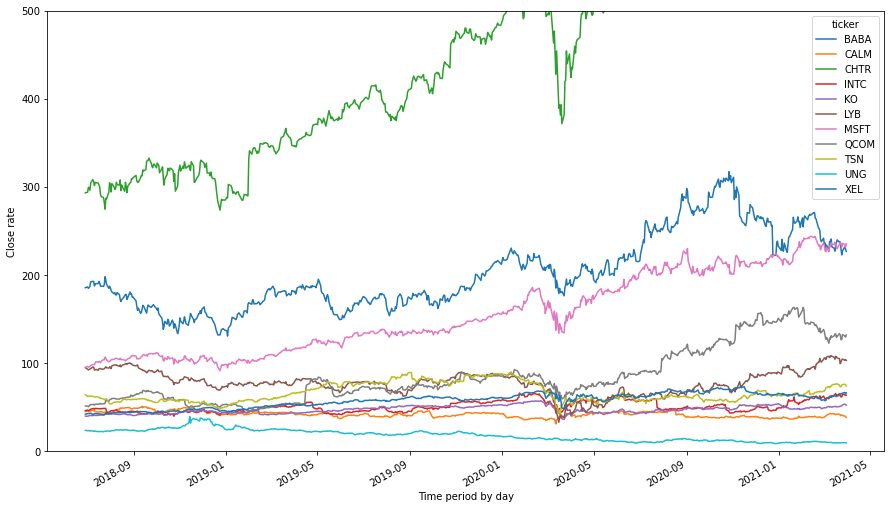

In [24]:
best_of_col_out = "bought_times"
top_stocks,yf_df,graph = create_top_20_dfs(main_stock_df,best_of_col_out,cols_dict_top_20,"2018-06-30","2021-04-01", 500)

In [23]:
top_stocks

,nameOfIssuer,titleOfClass,cusip,holding_duration,holding_proportion,portfolio_duration,Profit,yield_from_last_report,yield_from_1_year,yield_from_3_year,yield_from_continuous_profit,bought_times,ticker
0,FIAT CHRYSLER AUTOMOBILES N V,SHS,N31738102,6.125000,0.000260,0.001458,24.513958,-0.001458,0.0,0.0,0.0,31.000000,not_found
1,CDN IMPERIAL BK COMM TORONTO O,COM,136069101,3.500000,0.000015,0.000000,-3.100000,-0.035185,0.0,0.0,0.0,16.000000,not_found
2,LYONDELLBASELL INDUSTRIES N V,SHS - A -,N53745100,3.750000,0.000072,0.000000,0.731379,-0.097586,0.0,0.0,0.0,15.000000,LYB
3,COCA COLA EUROPEAN PARTNERS P,SHS,G25839104,2.625000,0.000150,0.000000,-11.602000,-0.288500,0.0,0.0,0.0,13.000000,not_found
4,CHARTER COMMUNICATIONS INC NEW,CL A,16119P108,2.750000,0.000048,0.000000,-8.181429,-0.519048,0.0,0.0,0.0,13.000000,CHTR
5,UNITED STATES NATL GAS FUND,UNIT PAR,912318300,1.916667,0.000014,0.000000,21.125711,0.010155,0.0,0.0,0.0,12.666667,UNG
6,Alibaba Group Holdin,SPON ADS EACH REP ONE ORD,01609W102,4.500000,0.001065,0.004783,65.987826,0.181304,0.0,0.0,0.0,11.000000,BABA
7,MELCO RESORT ENTERTAINMENT LTD,ADR,585464100,2.000000,0.000027,0.000000,-12.810667,-0.056000,0.0,0.0,0.0,11.000000,not_found
8,COGNIZANT TECH SOLUTIONS CRP,COM,192446102,11.000000,0.000441,0.003529,22.518235,0.005882,0.0,0.0,0.0,10.000000,not_found
9,CalMaineFoodsInc,COM,128030202,2.375000,0.001019,0.001875,71.606250,0.018750,0.0,0.0,0.0,10.000000,CALM
